<a href="https://colab.research.google.com/github/sayid-alt/kulitku-bangkit2024/blob/main/Machine%20Learning/skin_type/skin_type_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libarary

In [1]:
!pip install keras-tuner --upgrade

import zipfile
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner
import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from google.colab import files

import datetime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [2]:
print(tf.__version__)

2.17.0


# Download data from kaggle

In [3]:
!pip install kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sayidheykal","key":"86c1fb9d76a42fa13ddf5ec9e6ab5d99"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shakyadissanayake/oily-dry-and-normal-skin-types-dataset

Dataset URL: https://www.kaggle.com/datasets/shakyadissanayake/oily-dry-and-normal-skin-types-dataset
License(s): apache-2.0
 84% 105M/124M [00:01<00:00, 107MB/s] 
100% 124M/124M [00:01<00:00, 112MB/s]


# Utilities

In [5]:
def move_files(source_dir, destination_dir):
    # Ensure the source and destination directories exist
    if not os.path.exists(source_dir):
        print(f"The source directory '{source_dir}' does not exist.")
        return

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
        print(f"Created the destination directory '{destination_dir}'.")

    # List all files in the source directory
    files = os.listdir(source_dir)

    # Loop through all files and move them to the destination directory
    sum = 0
    for file_name in files:
        # Construct full file path
        source_file = os.path.join(source_dir, file_name)
        destination_file = os.path.join(destination_dir, file_name)

        # Move the file
        shutil.move(source_file, destination_file)
        sum+=1

    print(f'successfully moved {sum} files from {source_dir} to {destination_dir}')



def unzip_file(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

def create_directory(path):
    try:
        os.makedirs(path, exist_ok=True)
        print(f"Directory '{path}' created successfully.")
    except Exception as e:
        print(f"Error creating directory '{path}': {e}")



def count_files_and_directories(path):
    file_count = 0
    directory_count = 0

    for dirpath, dirnames, filenames in os.walk(path):
        # Count the number of files in the current directory
        file_count += len(filenames)
        # Count the number of subdirectories in the current directory
        directory_count += len(dirnames)

    return file_count, directory_count


def convert_keras_to_tflite(keras_model_path, tflite_model_path):
    # Load the TensorFlow model
    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model_path)

    # Convert the model to TFLite format
    tflite_model = converter.convert()

    # Save the converted model to a file
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model converted and saved to {tflite_model_path}")


def plot_portion(values, labels, title='Portion of values'):
  fig, ax = plt.subplots()

  sum_values = sum(values)
  percentages = [value / sum_values for value in values]

  bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

  # Create horizontal bar chart
  bars = ax.bar(labels, values, color=bar_colors, label=labels)

  # Add labels to bars with customizations
  ax.bar_label(bars, labels=[f'{round(v * 100, 2)} %' for v in percentages], padding=3, fontsize=10, label_type='center')

  # Set labels
  ax.set_ylabel('values')
  ax.set_title(title)
  ax.legend(title='categories')

  # Show the plot
  plt.show()

def plot_acc_loss(history):
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss values
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # save graph to png
  pngfile = 'acc_loss.png'
  if os.path.isfile(pngfile):
    plt.savefig('acc_loss(1).png')
  plt.savefig(f'acc_loss.png')

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  print(f'accuracy\t: {acc[len(acc)-1]}, val_accuracy\t: {val_acc[len(val_acc)-1]}')

  print(f'loss\t\t: {loss[len(loss)-1]}, val_loss\t: {val_loss[len(val_loss)-1]}')


def move_files_after_split(X, y, base_dir):
  sum = 0
  for source_dir, category in zip(X, y):
    filename = source_dir.split('/')[-1]
    destination_dir = os.path.join(base_dir, category, filename)
    shutil.move(source_dir, destination_dir)
    sum+= 1
  print(f'successfully moved {sum} files to {destination_dir}')

def checking_dir_qty(base_dir, train_dir, valid_dir, test_dir):
  num_train, num_train_labels = count_files_and_directories(train_dir)
  num_valid, num_valid_labels = count_files_and_directories(valid_dir)
  num_test, num_test_labels = count_files_and_directories(test_dir)

  all, _ = count_files_and_directories(base_dir)

  print(f'number of images: {all}\n-------------------\n')
  print(f'train data length: {num_train}\nNum of train labels: {num_train_labels}\npercentage: {round(num_train/all*100,2)} %\n')
  print(f'valid data length: {num_valid}\nNum of train labels: {num_valid_labels}\npercentage: {round(num_valid/all*100,2)} %\n')
  print(f'test data length: {num_test}\nNum of test labels: {num_test_labels}\npercentage: {round(num_test/all*100,2)} %\n')

def zip_directory(directory_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=directory_path)
                zipf.write(file_path, arcname=arcname)

    print(f'successfull zipping {directory_path} to {zip_path}')

def zip_file(file_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        zipf.write(file_path, arcname=file_path.split('/')[-1])

    print(f'successfull zipping {file_path} to {zip_path}')




In [6]:
dataset_dir = '/content/oily-dry-and-normal-skin-types-dataset'
if os.path.isdir(dataset_dir):
  shutil.rmtree(dataset_dir)

# Unzip dataset
zip_path = dataset_dir + '.zip'
unzip_file(zip_path)

# Generate data

In [7]:
# defined directories
# -------------------

# base working directory
base_dir = '/content/Oily-Dry-Skin-Types/'

# training data directory
train_dir = base_dir + 'train'

 # validation data directory
valid_dir = base_dir + 'valid'

# test data directory
test_dir = base_dir + 'test'

train_dir, valid_dir, test_dir

('/content/Oily-Dry-Skin-Types/train',
 '/content/Oily-Dry-Skin-Types/valid',
 '/content/Oily-Dry-Skin-Types/test')

## Gathering all picture to one folder as their categories

In [8]:
checking_dir_qty(base_dir, train_dir, valid_dir, test_dir)

number of images: 3153
-------------------

train data length: 2756
Num of train labels: 3
percentage: 87.41 %

valid data length: 262
Num of train labels: 3
percentage: 8.31 %

test data length: 134
Num of test labels: 3
percentage: 4.25 %



In [9]:
# define class names as a label
categories = [name for name in os.listdir(train_dir)]
categories

['normal', 'oily', 'dry']

In [10]:
# create dicertories for all existing data
all_dir = os.path.join(base_dir, 'all')

for cat in categories:
  create_directory(os.path.join(all_dir, cat))

# move all images to the all directory as a default before splitted
for dirname in [train_dir, valid_dir, test_dir]:
  for cat in categories:
    source_dir = os.path.join(dirname, cat)
    destination_dir = os.path.join(all_dir, cat)
    move_files(source_dir, destination_dir)


Directory '/content/Oily-Dry-Skin-Types/all/normal' created successfully.
Directory '/content/Oily-Dry-Skin-Types/all/oily' created successfully.
Directory '/content/Oily-Dry-Skin-Types/all/dry' created successfully.
successfully moved 1104 files from /content/Oily-Dry-Skin-Types/train/normal to /content/Oily-Dry-Skin-Types/all/normal
successfully moved 1000 files from /content/Oily-Dry-Skin-Types/train/oily to /content/Oily-Dry-Skin-Types/all/oily
successfully moved 652 files from /content/Oily-Dry-Skin-Types/train/dry to /content/Oily-Dry-Skin-Types/all/dry
successfully moved 111 files from /content/Oily-Dry-Skin-Types/valid/normal to /content/Oily-Dry-Skin-Types/all/normal
successfully moved 80 files from /content/Oily-Dry-Skin-Types/valid/oily to /content/Oily-Dry-Skin-Types/all/oily
successfully moved 71 files from /content/Oily-Dry-Skin-Types/valid/dry to /content/Oily-Dry-Skin-Types/all/dry
successfully moved 59 files from /content/Oily-Dry-Skin-Types/test/normal to /content/Oil

# EDA

Checking All data in test, train, valid folder (should be empty)

In [11]:
checking_dir_qty(base_dir, train_dir, valid_dir, test_dir)

number of images: 3153
-------------------

train data length: 0
Num of train labels: 3
percentage: 0.0 %

valid data length: 0
Num of train labels: 3
percentage: 0.0 %

test data length: 0
Num of test labels: 3
percentage: 0.0 %



## Look up the quantities of the category directory

normal : 1274
oily : 1120
dry : 758


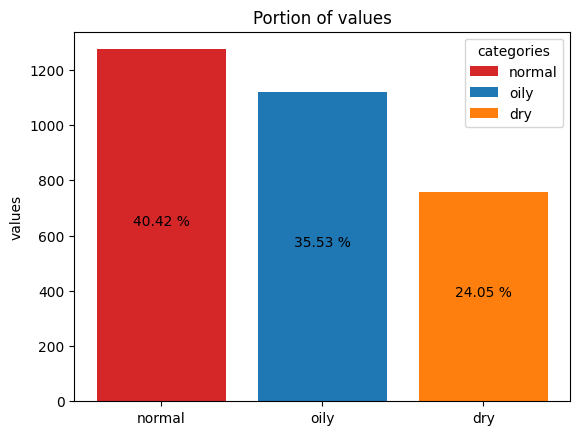

In [12]:
values = []
for i, class_name in enumerate(categories):
  class_length = len(os.listdir(os.path.join(all_dir, class_name)))
  values.append(class_length)
  print(f'{class_name} : {class_length}')

plot_portion(values, categories)

## Data Distribution

(array([1., 0., 2.]),
 array([ 758.,  930., 1102., 1274.]),
 <BarContainer object of 3 artists>)

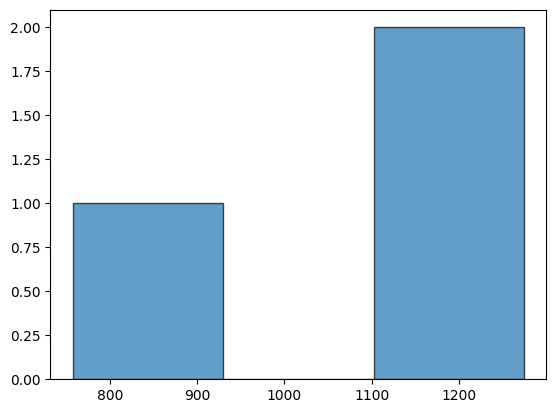

In [13]:
plt.hist(values, bins=3, alpha=0.7, edgecolor='black')

# Data Preprocessing

In [14]:
count_files_and_directories('/content/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/all')

(0, 0)

In [15]:
images, category = [], []
for cat in categories:
  path_cat = os.listdir(os.path.join(all_dir, cat))
  for image in path_cat:
    images.append(os.path.join(all_dir, cat, image))
    category.append('dry' if cat == 'dry' else 'normal' if cat == 'normal' else 'oily')


df = pd.DataFrame({'images':images, 'category':category})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.iloc[77]['images'].split('/')[-1]

'oily_3f8072c555504d75091b_jpg.rf.3f21abddf10806ba7d9c3ef570e0f3b8.jpg'

## Split data

In [16]:
# Split Train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(df['images'], df['category'],
                                                      test_size=0.2, random_state=42,
                                                      stratify=df['category'])

# Split validation set for test set
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.2,
                                                    random_state=42, stratify=y_valid)

train: 2521
valid: 504
X_test : 127


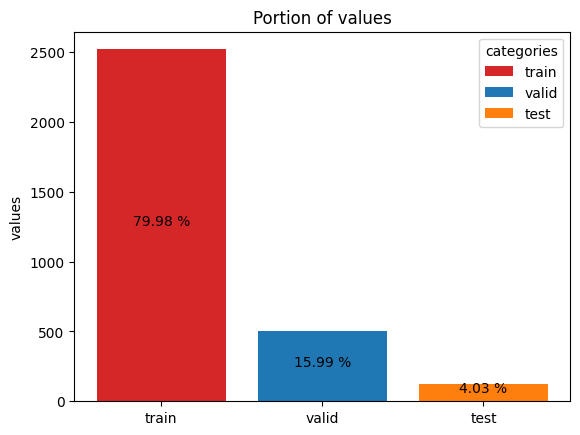

In [17]:
# check qty of split
print(f'train: {len(X_train)}\nvalid: {len(X_valid)}\nX_test : {len(X_test)}')
plot_portion(values=[len(X_train), len(X_valid), len(X_test)], labels=['train', 'valid', 'test'])

In [18]:
# Moving a train files to train directory
move_files_after_split(X_train, y_train, train_dir)
move_files_after_split(X_valid, y_valid, valid_dir)
move_files_after_split(X_test, y_test, test_dir)

successfully moved 2521 files to /content/Oily-Dry-Skin-Types/train/dry/dry_b6e19643f8ac3df37c18_jpg.rf.d3e2f07a8ffe38058aa629cfc0b9d1ad.jpg
successfully moved 504 files to /content/Oily-Dry-Skin-Types/valid/oily/oily_b62ff7193268b0b90e57_jpg.rf.c3afe4b3a2471237b640477a6e485949.jpg
successfully moved 127 files to /content/Oily-Dry-Skin-Types/test/dry/dry_12452a61218e358e7cfc_jpg.rf.6a7c898c1c471cf0c00436bcc7b745e9.jpg


In [19]:
# Check if the images from (all) category is moved
count_files_and_directories(os.path.join(base_dir, 'all'))

(0, 3)

In [20]:
# Check if the images is moved as a split portion
print(count_files_and_directories(os.path.join(base_dir, 'test'))) # return len of (files, directories)
print(count_files_and_directories(os.path.join(base_dir, 'train')))# return len of (files, directories
print(count_files_and_directories(os.path.join(base_dir, 'valid')))# return len of (files, directories

(127, 3)
(2521, 3)
(504, 3)


# Download splitted dataset

In [21]:
# remove temp file -(all) category-
shutil.rmtree(os.path.join(base_dir, 'all'))

## Zipping splitted dataset file

In [22]:
directory_path = base_dir
zip_path = 'skin-type-dataset.zip'
zip_directory(directory_path, zip_path)
print(f"Directory '{directory_path}' has been zipped as '{zip_path}'")

successfull zipping /content/Oily-Dry-Skin-Types/ to skin-type-dataset.zip
Directory '/content/Oily-Dry-Skin-Types/' has been zipped as 'skin-type-dataset.zip'


# Generate Data (after split 80/15/5)

In [23]:
# Unzip dataset
zip_path = '/content/skin-type-dataset.zip'
dataset_path = '/content/skin_type_dataset'

if os.path.isdir(dataset_path):
  shutil.rmtree(dataset_path)

unzip_file(zip_path, extract_to=dataset_path)

In [24]:
# defined directories
# -------------------

# base working directory
base_dir = dataset_path

# remove readme file
readme_file = os.path.join(base_dir, 'README.dataset.txt')
if os.path.isfile(readme_file):
  os.remove(readme_file)

# training data directory
train_dir = os.path.join(base_dir, 'train')

 # validation data directory
valid_dir =os.path.join(base_dir, 'valid')

# test data directory
test_dir = os.path.join(base_dir, 'test')

train_dir, valid_dir, test_dir

('/content/skin_type_dataset/train',
 '/content/skin_type_dataset/valid',
 '/content/skin_type_dataset/test')

## Data generator

In [25]:
# create imageDataGenerator instance
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [153]:
# create Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

validation_generator = validation_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='categorical'
                                                    )

test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224,224),
                                                    class_mode='categorical'
                                                    )

Found 2521 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 127 images belonging to 3 classes.


In [27]:
train_generator.class_indices

{'dry': 0, 'normal': 1, 'oily': 2}

# Data Visualitaion

In [28]:
split_names = ['train','valid', 'test']
num_train, _ = count_files_and_directories(train_dir)
num_valid, _ = count_files_and_directories(valid_dir)
num_test, _ = count_files_and_directories(test_dir)
values = [num_train, num_valid, num_test]

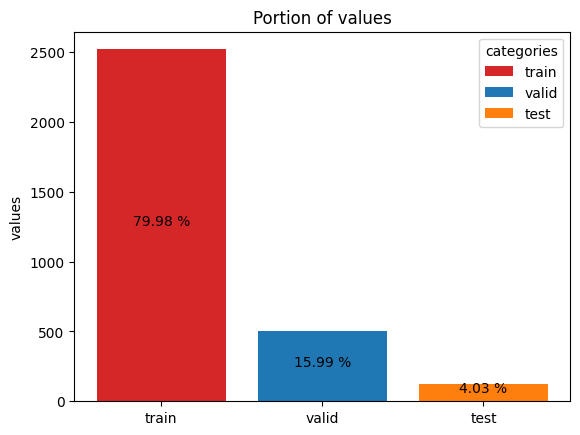

In [29]:
plot_portion(values, split_names)

# Build model

In [30]:
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [32]:
def build_model(hp):
  x = base_model.output

  if hp.Boolean("flatten"):
      x = Flatten()(x)
  elif hp.Boolean("global_average_pooling"):
      x = GlobalAveragePooling2D()(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=1024, step=32),
        activation='relu')(x)

  # Tune whether to use dropout.
  if hp.Boolean("dropout"):
      x = Dropout(rate=0.25)(x)

  x = Dense(
        # Tune number of units.
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation='relu')(x)

  if hp.Boolean("batch_normalization"):
    x = BatchNormalization()(x)

  predictions = Dense(3, activation='softmax')(x)

  # Create model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Define the optimizer learning rate as a hyperparameter.
  learning_rate = hp.Float("learning_rate", min_value=1e-6, max_value=1e-2, sampling="log")

  # Define learning rate scheduler
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(optimizer=Adam(learning_rate=lr_schedule),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  tf.keras.utils.plot_model(model, to_file='model_graph.png', show_shapes=True)

  return model

# create a model
model = build_model(keras_tuner.HyperParameters())
model.summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.529166 to fit



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 23,631,523 (90.15 MB)

 Trainable params: 23,586,083 (89.97 MB)

 Non-trainable params: 45,440 (177.50 KB)

## Hyperparameter tuning

In [33]:
# define tuner using RandomSearch
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    overwrite=False,
    directory="keras_tuner",
    project_name="skin_type_model",
)

# print search space summary
tuner.search_space_summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.529166 to fit

Search space summary
Default search space size: 6
flatten (Boolean)
{'default': False, 'conditions': []}
global_average_pooling (Boolean)
{'default': False, 'conditions': []}
dropout (Boolean)
{'default': False, 'conditions': []}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
batch_normalization (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [34]:
# start search best parameters
tuner.search(train_generator, epochs=2, validation_data=validation_generator)

Trial 5 Complete [00h 00m 10s]

Best val_accuracy So Far: 0.4841269850730896
Total elapsed time: 00h 15m 02s


## Query Result

In [35]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.520756 to fit



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 357 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 26,585,443 (101.42 MB)

 Trainable params: 26,540,003 (101.24 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [38]:
best_model.save('best_model.keras')

In [ ]:
# tuner.results_summary()

In [ ]:
# !zip -r /content/skin_type_model.zip /content/keras_tuner/skin_type_model

In [ ]:
# files.download('/content/skin_type_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Retrain Models

In [39]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
for hp in best_hps:
  print(hp.values)
# Build the model with the best hp.
model =  build_model(best_hps[0])

{'flatten': False, 'global_average_pooling': True, 'dropout': True, 'units': 992, 'batch_normalization': False, 'learning_rate': 2.4889475756671172e-05}
{'flatten': False, 'global_average_pooling': True, 'dropout': False, 'units': 704, 'batch_normalization': True, 'learning_rate': 0.0006284490000809772}
{'flatten': True, 'global_average_pooling': True, 'dropout': False, 'units': 608, 'batch_normalization': True, 'learning_rate': 1.3119808291928485e-05}
{'flatten': False, 'global_average_pooling': False, 'dropout': True, 'units': 352, 'batch_normalization': False, 'learning_rate': 1.987824751706444e-06}
{'flatten': False, 'global_average_pooling': False, 'dropout': True, 'units': 160, 'batch_normalization': False, 'learning_rate': 0.0054294378899083905}
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.520756 to fit



### Set Callbacks

In [40]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/ckpt/model_{epoch:02d}_{accuracy:.2f}_{val_accuracy:.2f}_v02.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

backup_restore = keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

csv_logger = tf.keras.callbacks.CSVLogger(f'/content/csv_logger.csv')

In [41]:

def train_model(model, epochs, steps_per_epoch, unfreeze=None, callbacks=None):

  # if freeze is not none
  if unfreeze:
    # Freeze the layers except the last 5 layers
    for layer in model.layers[:-unfreeze]:
      layer.trainable = False


  model.summary()
  history = model.fit(train_generator, epochs=epochs,
            batch_size=32,
            verbose=2,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // validation_generator.batch_size,
            callbacks=[callbacks])

  return history

In [42]:
EPOCHS = 50
steps_per_epoch = train_generator.samples // train_generator.batch_size
callbacks = [ckpt_callback, csv_logger]

In [43]:

history = train_model(model, epochs=EPOCHS,
                      steps_per_epoch=steps_per_epoch,
                      callbacks=callbacks)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 26,585,443 (101.42 MB)

 Trainable params: 26,540,003 (101.24 MB)

 Non-trainable params: 45,440 (177.50 KB)

Epoch 1/50
78/78 - 97s - 1s/step - accuracy: 0.4383 - loss: 1.0585 - val_accuracy: 0.4917 - val_loss: 1.0211
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


78/78 - 3s - 42ms/step - accuracy: 0.4688 - loss: 1.0941 - val_accuracy: 0.5417 - val_loss: 0.9712
Epoch 3/50
78/78 - 31s - 403ms/step - accuracy: 0.5279 - loss: 0.9637 - val_accuracy: 0.5375 - val_loss: 0.9671
Epoch 4/50
78/78 - 2s - 23ms/step - accuracy: 0.5312 - loss: 1.0652 - val_accuracy: 0.6250 - val_loss: 0.7535
Epoch 5/50
78/78 - 31s - 398ms/step - accuracy: 0.5854 - loss: 0.8901 - val_accuracy: 0.5917 - val_loss: 0.9200
Epoch 6/50
78/78 - 0s - 1ms/step - accuracy: 0.5312 - loss: 0.8268 - val_accuracy: 0.6250 - val_loss: 0.7217
Epoch 7/50
78/78 - 31s - 401ms/step - accuracy: 0.6127 - loss: 0.8204 - val_accuracy: 0.6083 - val_loss: 0.8398
Epoch 8/50
78/78 - 0s - 990us/step - accuracy: 0.6562 - loss: 0.7769 - val_accuracy: 0.5833 - val_loss: 0.9845
Epoch 9/50
78/78 - 33s - 421ms/step - accuracy: 0.6786 - loss: 0.7367 - val_accuracy: 0.6604 - val_loss: 0.7719
Epoch 10/50
78/78 - 2s - 23ms/step - accuracy: 0.5625 - loss: 0.8834 - val_accuracy: 0.7083 - val_loss: 0.9413
Epoch 11/50


# Evaluation

accuracy	: 0.9375, val_accuracy	: 0.875
loss		: 0.15795749425888062, val_loss	: 0.6821854114532471


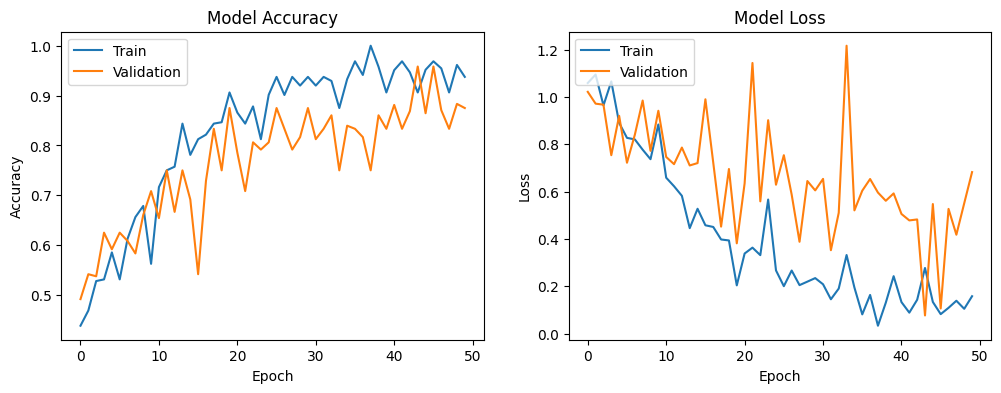

In [48]:
# Plot training & validation accuracy values
plot_acc_loss(history)

## Download best model after retrained

In [44]:
model_retrained_path = '/content/ckpt/model_44_0.91_0.96_v02.keras'

# uncomment for download
files.download(model_retrained_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
zip_file(model_retrained_path, 'model_retrained.zip')

successfull zipping /content/ckpt/model_44_0.91_0.96_v02.keras to model_retrained.zip


In [46]:
# Load saved Model from checkpoint
model_retrained = tf.keras.models.load_model(model_retrained_path)

In [47]:
# evaluate on test images
val_loss, val_accuracy = model_retrained.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.9414 - loss: 0.4230
Validation Loss: 0.39985474944114685
Validation Accuracy: 0.9375


## Visualize the predicted

In [235]:
# Get the class indices
class_indices = test_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}
print(f'labels: {class_labels}')

labels: {0: 'dry', 1: 'normal', 2: 'oily'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted_classes:[0 2 2 1 2 0 2 1 2 0]
true_classes	 :[2 2 2 1 2 2 2 1 2 0]

shape: (127,)	 (127,) 	 (127, 224, 224, 3)


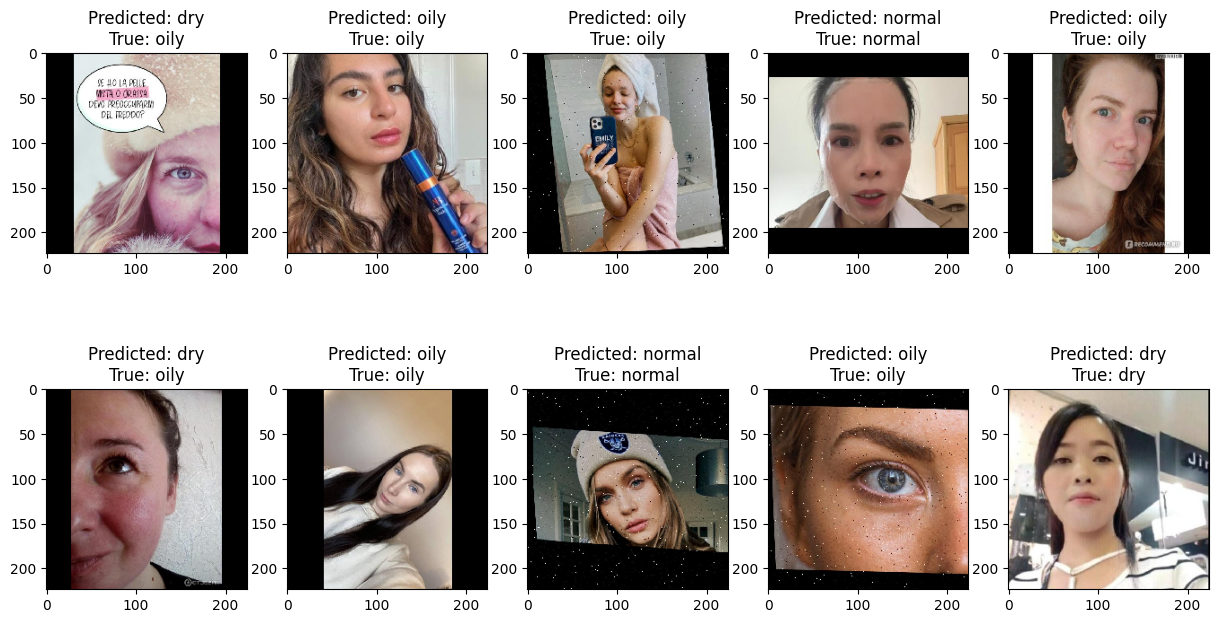

In [256]:
# Predict using the model
labels = []
images = []
predictions = []
for i in range(len(test_generator)):
  _images, _labels = next(test_generator)
  predictions.append(model_retrained.predict(_images))
  labels.append(_labels)
  images.append(_images)

predictions = np.concatenate(predictions)
images = np.concatenate(images)
labels = np.concatenate(labels)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

print(f'predicted_classes:{predicted_classes[:10]}\ntrue_classes\t :{true_classes[:10]}')
print(f'\nshape: {predicted_classes.shape}\t {true_classes.shape} \t {images.shape}')


# # Plot the first 10 predicted images
ncols = 5
nrows = images[:10].shape[0] // ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,4*nrows))
axes = axes.flatten()
for i, image in enumerate(images[:10]):
    axes[i].imshow(image)
    axes[i].set_title(f'Predicted: {class_labels[predicted_classes[i]]}\nTrue: {class_labels[true_classes[i]]}')

plt.show()

In [257]:
true_classes.shape, predicted_classes.shape

((127,), (127,))

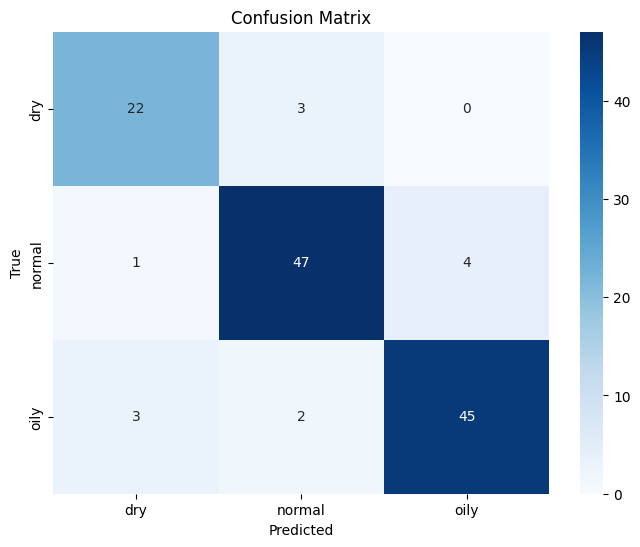

In [258]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [259]:
from sklearn.metrics import classification_report

# Assuming you have true_classes and predicted_classes from the previous code
report = classification_report(true_classes, predicted_classes, target_names=list(test_generator.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

         dry       0.85      0.88      0.86        25
      normal       0.90      0.90      0.90        52
        oily       0.92      0.90      0.91        50

    accuracy                           0.90       127
   macro avg       0.89      0.89      0.89       127
weighted avg       0.90      0.90      0.90       127



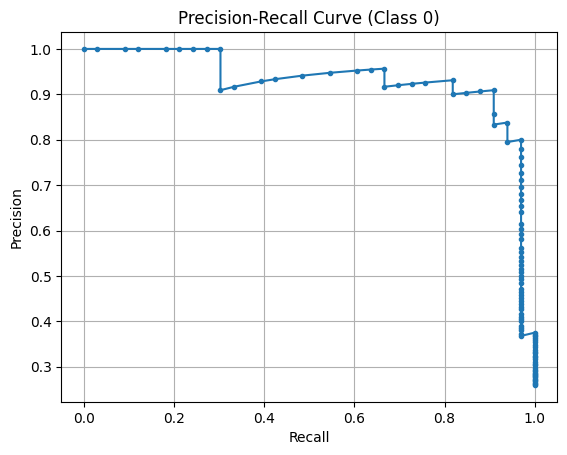

In [254]:
from sklearn.metrics import precision_recall_curve

# Choose a class for precision-recall curve (e.g., class 0)
class_index = 0

# Get probabilities for the chosen class
probs = predictions[:, class_index]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(
    (true_classes == class_index).astype(int),  # Binary representation of the chosen class
    probs
)


# Plot the precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Class {class_index})')
plt.grid(True)
plt.show()

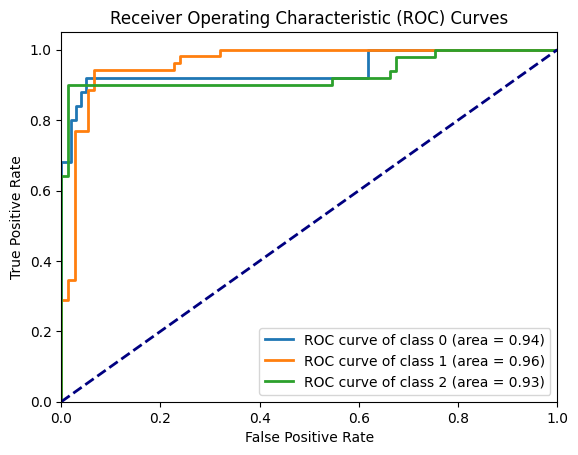

In [261]:
# Assuming you have true_classes and predicted_classes from the previous code
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3 # Number of classes in your dataset

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Convert model for deployment

## Convert keras model to tflite

In [ ]:
tflite_model_path = 'skin_type_model.tflite'
convert_keras_to_tflite(model_retrained, tflite_model_path)

Model converted and saved to skin_type_model.tflite


## Convert savedModel to tfjs

### Freeze a TensorFlow Model

## TFJS converter

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 109.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
   

In [ ]:
!pip install 'keras<3.0.0' mediapipe-model-maker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (set

In [ ]:
import tensorflow as tf

from tensorflow.keras.layers import BatchNormalization
print(tf.__version__)
# Custom layer to replace unsupported operations
class CustomBatchNormalization(BatchNormalization):
    def call(self, inputs, training=False):
        return super().call(inputs, training=training)

# Load the Keras model and replace BatchNormalization layers
# zip_path = 'model_retrained.zip'
# unzip_file(zip_path, extract_to='model_retrained.keras')

model_path = 'model_retrained.keras'
keras_model = tf.keras.models.load_model('/content/ckpt/model_24_0.95_0.90_v02.keras', custom_objects={'BatchNormalization': CustomBatchNormalization})



2.15.1


In [ ]:
!pip install tensorflowjs

  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached tf_keras-2.16.0-py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.1
    Uninstalling tensorflow-2.15.1:
      Successfully uninstalled tensorflow-2.15.1
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.15.1
    Uninstalling tf_keras-2.15.1:
      Successfully uninstalled tf_keras-2.15.1
ERROR: pip's dependency resolver does not currently take into accou

In [ ]:
# Save the modified model in the SavedModel format
# keras_model.save('saved_model')
import tensorflowjs as tfjs
# Convert the SavedModel to TensorFlow.js format
tfjs.converters.convert_tf_saved_model('saved_model', 'model_tfjs', skip_op_check=True)

In [ ]:
# zipping tfjs converted directory

zip_directory(directory_path='//content/model_tfjs', zip_path='/content/skin_type_model_tfjs.zip')

successfull zipping //content/model_tfjs to /content/skin_type_model_tfjs.zip
